<a href="https://colab.research.google.com/github/zhulkhoirr/Steam-Recommendation-System/blob/main/SteamRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Rekomendasi Game Pada Platform Steam

## 1. Download Datasets Dari Kaggle

In [40]:
from google.colab import files
files.upload()

Saving model.zip to model.zip


In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam

Dataset URL: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam
License(s): CC0-1.0
100% 658M/660M [00:26<00:00, 39.0MB/s]
100% 660M/660M [00:26<00:00, 26.4MB/s]


In [41]:
!unzip -q model.zip

In [7]:
!unzip -q game-recommendations-on-steam.zip

## 2. Memahami Data

In [8]:
import numpy as np
import pandas as pd

In [9]:
recommendations_df = pd.read_csv('recommendations.csv')

recommendations_df.sample(5)

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
3027964,1172620,0,0,2021-01-28,True,75.6,1512309,3027964
32818995,884660,0,0,2020-12-05,True,45.6,6514372,32818995
30530743,274500,0,0,2016-06-02,True,0.5,4513348,30530743
2432117,440900,0,0,2022-01-14,True,477.1,10011457,2432117
31030623,1763050,2,0,2022-01-07,True,3.1,11378545,31030623


In [10]:
games_df = pd.read_csv('games.csv')

games_df.sample(5)

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
5443,300380,Road Redemption,2017-10-04,True,True,True,Very Positive,82,8387,19.99,19.99,0.0,True
21070,587660,Leaving Lyndow Original Soundtrack,2017-02-08,False,False,False,Positive,92,14,0.00,0.00,0.0,True
14862,2139268,Call of Duty League™ - New York Subliners Pack...,2022-11-29,True,False,False,Positive,92,13,9.99,9.99,0.0,True
41381,531890,Guardian's Oath,2016-09-28,True,False,False,Positive,93,15,0.99,0.99,0.0,True
2420,556210,FSX Steam Edition: Beechcraft® Duchess 76 Add-On,2017-05-04,True,False,False,Positive,83,18,16.99,16.99,0.0,True


In [11]:
sorted_df = games_df.sort_values(by='user_reviews', ascending=False).head(10)

sorted_df

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
14398,730,Counter-Strike: Global Offensive,2012-08-21,True,True,True,Very Positive,88,7494460,15.0,0.0,0.0,True
47770,578080,PUBG: BATTLEGROUNDS,2017-12-21,True,False,False,Mixed,57,2217226,0.0,0.0,0.0,True
13176,570,Dota 2,2013-07-09,True,True,True,Very Positive,82,2045628,0.0,0.0,0.0,True
12717,271590,Grand Theft Auto V,2015-04-13,True,False,False,Very Positive,86,1484122,0.0,0.0,0.0,True
14535,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,True,False,False,Very Positive,86,993312,20.0,0.0,0.0,True
47380,440,Team Fortress 2,2007-10-10,True,True,True,Very Positive,93,985819,0.0,0.0,0.0,True
13035,105600,Terraria,2011-05-16,True,True,True,Overwhelmingly Positive,97,943413,10.0,0.0,0.0,True
15363,4000,Garry's Mod,2006-11-29,True,True,True,Overwhelmingly Positive,96,853733,10.0,0.0,0.0,True
13173,252490,Rust,2018-02-08,True,True,False,Very Positive,87,786668,40.0,0.0,0.0,True
14376,1172470,Apex Legends™,2020-11-04,True,False,False,Very Positive,80,713182,0.0,0.0,0.0,True


In [12]:
import json

with open('games_metadata.json', 'r') as file:
    data = file.read()

json_objects = data.split('\n')

data_list = []
for obj in json_objects:
    if obj.strip():
        data_list.append(json.loads(obj))

games_metadata_df = pd.DataFrame(data_list)
games_metadata_df['tags'] = games_metadata_df['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
games_metadata_df.sample(5)


,app_id,description,tags
30668,2154890,A dangerous class to survive begins! A 30-minu...,"Action Roguelike, Action, Roguelike, Bullet He..."
9872,1148650,A puzzle based deck building rogue-like preque...,"Roguelite, Indie, Strategy, Adventure, Puzzle,..."
16889,2023670,Incoherence is a fragmented first-person point...,"Adventure, Point & Click, Puzzle, 2D, First-Pe..."
34667,599040,Win That War! is a massive scale real-time str...,"Strategy, Massively Multiplayer, Indie, Early ..."
2868,1983244,,Action


In [13]:
gg = games_metadata_df[games_metadata_df['app_id'] == 409710]

gg

,app_id,description,tags
25126,409710,"BioShock is a shooter unlike any other, loaded...","FPS, Story Rich, Atmospheric, Horror, Singlepl..."


In [14]:
games_with_metadata_df = pd.merge(games_df, games_metadata_df, on='app_id', how='outer')

selected_columns = ['app_id', 'title', 'rating', 'user_reviews', 'price_final', 'description', 'tags']

games_with_metadata_df = games_with_metadata_df[selected_columns]

games_with_metadata_df.sample(5)

,app_id,title,rating,user_reviews,price_final,description,tags
48027,702890,BlazBlue: Cross Tag Battle,Very Positive,2809,19.99,THE COLLISION IS INEVITABLE! THE IMPACT WILL B...,"2D Fighter, Anime, Fighting, Action, Great Sou..."
48376,1139900,Ghostrunner,Very Positive,36852,8.99,Ghostrunner offers a unique single-player expe...,"Action, Cyberpunk, Fast-Paced, First-Person, D..."
7684,392950,Lost Lands: A Hidden Object Adventure,Very Positive,5149,0.00,"Persecuted by ill fate, the elven nation land ...","Free to Play, Hidden Object, Adventure, Casual..."
30943,882760,Nom Nom Apocalypse,Mixed,12,5.99,Nom Nom Apocalypse is a twinstick shooter set ...,"Action, Indie, Top-Down Shooter, Twin Stick Sh..."
26330,1800730,I MAED A GAM3 W1TH Z0MB1ES 1N IT!!!1,Overwhelmingly Positive,1258,0.00,A top down twin stick zombie slaying shooter t...,"Zombies, Twin Stick Shooter, Top-Down Shooter,..."


In [15]:
filtered_df = games_with_metadata_df[selected_columns]

sorted_df = filtered_df.sort_values(by='user_reviews', ascending=False).head(10)

sorted_df

,app_id,title,rating,user_reviews,price_final,description,tags
14398,730,Counter-Strike: Global Offensive,Very Positive,7494460,15.0,,
47770,578080,PUBG: BATTLEGROUNDS,Mixed,2217226,0.0,,
13176,570,Dota 2,Very Positive,2045628,0.0,,
12717,271590,Grand Theft Auto V,Very Positive,1484122,0.0,,
14535,359550,Tom Clancy's Rainbow Six® Siege,Very Positive,993312,20.0,,
47380,440,Team Fortress 2,Very Positive,985819,0.0,,
13035,105600,Terraria,Overwhelmingly Positive,943413,10.0,,
15363,4000,Garry's Mod,Overwhelmingly Positive,853733,10.0,,
13173,252490,Rust,Very Positive,786668,40.0,,
14376,1172470,Apex Legends™,Very Positive,713182,0.0,,


In [16]:
users_df = pd.read_csv('users.csv')

users_df.sample(5)

,user_id,products,reviews
82523,13233660,47,1
13128492,8936628,23,1
5830073,7134967,247,4
8381935,13010084,847,9
3288448,3300783,7,1


# Neural Collaborative Filtering

## 1. Mempersiapkan Data

In [17]:
recommendations_df = pd.read_csv('recommendations.csv', usecols=['app_id', 'is_recommended', 'user_id', 'hours'])

recommendations_df.head(5)

,app_id,is_recommended,hours,user_id
0,975370,True,36.3,51580
1,304390,False,11.5,2586
2,1085660,True,336.5,253880
3,703080,True,27.4,259432
4,526870,True,7.9,23869


In [18]:
hours_count = recommendations_df[recommendations_df['hours'] == 0.0].count()

print(f"Jumlah nilai 0.0 di kolom 'hours': {hours_count['hours']}")

Jumlah nilai 0.0 di kolom 'hours': 176329


In [19]:
recommendations_df = recommendations_df[recommendations_df['hours'] != 0.0]

In [20]:
zero_hours_count = (recommendations_df['hours'] == 0.0).sum()

print(f"Jumlah nilai 0.0 di kolom 'hours': {zero_hours_count}")

Jumlah nilai 0.0 di kolom 'hours': 0


In [21]:
n_recommendations = recommendations_df['user_id'].value_counts()
print(n_recommendations)

user_id
11764552    5652
5112758     3657
11656130    3648
5669734     3479
11553593    3118
            ... 
5586939        1
4497103        1
2719342        1
7185639        1
2306695        1
Name: count, Length: 13760373, dtype: int64


In [22]:
n_recommendations = recommendations_df['user_id'].value_counts()
recommendations_df = recommendations_df[recommendations_df['user_id'].isin(n_recommendations[n_recommendations >=50].index)].copy()
recommendations_df.head(5)

,app_id,is_recommended,hours,user_id
58,602960,True,41.9,737481
138,570940,False,73.3,5136277
151,1196590,True,19.0,5935019
203,304390,False,42.5,10567745
209,244850,True,540.7,11143713


In [23]:
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 1


In [24]:
recommendations_df.drop_duplicates(inplace=True)
print("Jumlah duplikasi:",  recommendations_df.duplicated().sum())

Jumlah duplikasi: 0


In [25]:
recommendations_df.isnull().sum()

app_id            0
is_recommended    0
hours             0
user_id           0
dtype: int64

In [26]:
recommendations_df['is_recommended'] = recommendations_df['is_recommended'].astype(int)

## 2. Preprocessing Data

In [27]:
user_ids = recommendations_df['user_id'].unique().tolist()
user2user_encoded = {x:i for i, x in enumerate(user_ids)}
user_encoded2user = {i:x for i, x in enumerate(user_ids)}
recommendations_df['user'] = recommendations_df['user_id'].map(user2user_encoded)
n_users = len(user2user_encoded)

app_ids = recommendations_df['app_id'].unique().tolist()
app2app_encoded = {x:i for i, x in enumerate(app_ids)}
app_encoded2app = {i:x for i, x in enumerate(app_ids)}
recommendations_df['app'] = recommendations_df['app_id'].map(app2app_encoded)
n_app  = len(app2app_encoded)

print("Jumlah user: {}, Jumlah game: {}".format(n_users, n_app))

Jumlah user: 36646, Jumlah game: 36028


In [28]:
recommendations_df

,app_id,is_recommended,hours,user_id,user,app
58,602960,1,41.9,737481,0,0
138,570940,0,73.3,5136277,1,1
151,1196590,1,19.0,5935019,2,2
203,304390,0,42.5,10567745,3,3
209,244850,1,540.7,11143713,4,4
...,...,...,...,...,...,...
41154764,1818450,1,1.0,13261742,24873,991
41154770,700600,1,2.0,6382076,35046,2837
41154771,362960,1,35.0,7858713,21437,3024
41154784,633230,0,20.0,8107668,18148,2391


In [29]:
recommendations_df = recommendations_df.sample(frac=1, random_state=46)

X = recommendations_df[['user', 'app']].values
y = recommendations_df['is_recommended']

In [30]:
X

array([[ 8127,    52],
       [ 5147, 27858],
       [ 6385,  2674],
       ...,
       [30719,  1078],
       [ 7675,   401],
       [23746, 25712]])

In [31]:
y

13131890    1
35625112    1
16695870    1
14523913    1
6006244     1
           ..
3402980     0
36455208    1
9328930     0
19537234    1
36598476    0
Name: is_recommended, Length: 3376881, dtype: int64

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print("Train set is_recommended: {}".format(len(y_train)))
print("Test set is_recommended: {}".format(len(y_test)))

Train set is_recommended: 2701504
Test set is_recommended: 675377


In [33]:
X_train

array([[29438,  3890],
       [ 3727, 23255],
       [   55,   745],
       ...,
       [  991, 27745],
       [35784, 27875],
       [25174,  1776]])

In [34]:
X_train[:, 0]

array([29438,  3727,    55, ...,   991, 35784, 25174])

In [35]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [36]:
X_train_array

[array([29438,  3727,    55, ...,   991, 35784, 25174]),
 array([ 3890, 23255,   745, ..., 27745, 27875,  1776])]

## 3. Membuat Model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, Dot, BatchNormalization

def RecommenderNet(n_users, n_app, embedding_size=32):
  user_input = Input(shape=(1), name='user')
  user_embedding = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
  app_input = Input(shape=(1), name='app')
  app_embedding = Embedding(n_app, embedding_size, name='app_embedding')(app_input)

  # concatenate = Concatenate(name='concatenate')([user_vec, app_vec])
  dot = Dot(axes=1, normalize=True, name='dot')([user_embedding, app_embedding])
  flatten = Flatten(name='flatten')(dot)

  dense = Dense(128, activation='relu', name='dense')(flatten)
  dropout = Dropout(0.4, name='dropout')(dense)
  batch_norm = BatchNormalization(name='batch_norm')(dropout)
  output = Dense(1, activation='sigmoid', name='output')(batch_norm)

  model = Model([user_input, app_input], output)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'mse'])

  return model

model = RecommenderNet(n_users, n_app)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 app (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 32)                1172672   ['user[0][0]']                
                                                                                                  
 app_embedding (Embedding)   (None, 1, 32)                1152896   ['app[0][0]']                 
                                                                                              

In [ ]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    epochs=15,
    batch_size=256,
    validation_data=(X_test_array, y_test)
)

Epoch 1/15
10553/10553 [==============================] - 423s 40ms/step - loss: 0.4956 - mae: 0.3152 - mse: 0.1580 - val_loss: 0.4871 - val_mae: 0.3058 - val_mse: 0.1550
Epoch 2/15
10553/10553 [==============================] - 430s 41ms/step - loss: 0.4828 - mae: 0.3068 - mse: 0.1535 - val_loss: 0.4790 - val_mae: 0.3066 - val_mse: 0.1522
Epoch 3/15
10553/10553 [==============================] - 442s 42ms/step - loss: 0.4748 - mae: 0.3015 - mse: 0.1508 - val_loss: 0.4732 - val_mae: 0.3063 - val_mse: 0.1502
Epoch 4/15
10553/10553 [==============================] - 432s 41ms/step - loss: 0.4680 - mae: 0.2969 - mse: 0.1485 - val_loss: 0.4677 - val_mae: 0.3005 - val_mse: 0.1484
Epoch 5/15
10553/10553 [==============================] - 462s 44ms/step - loss: 0.4620 - mae: 0.2929 - mse: 0.1465 - val_loss: 0.4632 - val_mae: 0.2995 - val_mse: 0.1469
Epoch 6/15
10553/10553 [==============================] - 457s 43ms/step - loss: 0.4568 - mae: 0.2894 - mse: 0.1447 - val_loss: 0.4595 - val_mae:

In [ ]:
loss, mae, mse = model.evaluate(X_test_array, y_test)

print(f'Loss: {loss}, MAE: {mae}, MSE: {mse}')

21106/21106 [==============================] - 70s 3ms/step - loss: 0.4349 - mae: 0.2733 - mse: 0.1374
Loss: 0.43489643931388855, MAE: 0.27329787611961365, MSE: 0.13736818730831146


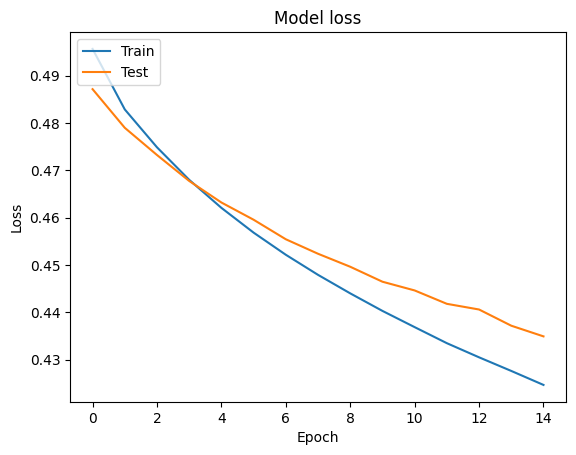

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save('model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Metadata Game Steam

In [46]:
print('Pilih user random')

recommendation_per_user = recommendations_df.groupby('user_id').size()

random_user =  recommendation_per_user[recommendation_per_user > 50].sample(1).index[0]

print(f'user_id: {random_user}')

Pilih user random
user_id: 3532411


In [47]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print(f'Game yang direkomendasikan untuk user: {random_user}')
print('===' * 25)

game_played_by_user = recommendations_df[recommendations_df.user_id == random_user]
game_not_played_df = games_with_metadata_df[~games_with_metadata_df['app_id'].isin(game_played_by_user.app_id.values)]
game_not_played = list(set(game_not_played_df['app_id']).intersection(set(app2app_encoded.keys())))
game_not_played = [[app2app_encoded.get(x)] for x in game_not_played if x in app2app_encoded]

user_encoder = user2user_encoded.get(random_user)
user_game_array = np.hstack(([[user_encoder]] * len(game_not_played), game_not_played))
user_game_array = [user_game_array[:, 0], user_game_array[:, 1]]

recommendations = model.predict(user_game_array).flatten()
top_recommendations = (-recommendations).argsort()[:10]

recommended_games_ids = [app_encoded2app.get(game_not_played[top_recommendations[x]][0]) for x in range(len(top_recommendations)) if game_not_played[top_recommendations[x]][0] in app_encoded2app]

results = []
top_recommendations_ids = []

for index, app_id in enumerate(game_not_played):
  recommendation = recommendations[index]
  id_ = app_encoded2app.get(app_id[0])

  if id_ in recommended_games_ids:
    top_recommendations_ids.append(id_)
    try:
      condition = (games_with_metadata_df.app_id == id_)
      if games_with_metadata_df[condition].empty:
        print(f"No metadata found for game ID {id_}")
        continue

      title = games_with_metadata_df[condition]['title'].values[0]
      rating = games_with_metadata_df[condition]['rating'].values[0]
      user_reviews = games_with_metadata_df[condition]['user_reviews'].values[0]
      price_final = games_with_metadata_df[condition]['price_final'].values[0]
      description = games_with_metadata_df[condition]['description'].values[0]
      tags = games_with_metadata_df[condition]['tags'].values[0]

      results.append({
        'title': title,
        'pred_recommendations': recommendation,
        'rating': rating,
        'user_reviews': user_reviews,
        'price_final': price_final,
        'description': description,
        'tags': tags
      })
    except Exception as e:
        print(f"Error processing game {id_}: {e}")
        continue

print("---" * 25)
print("> Top 10 game recommendations")
print("---" * 25)

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='pred_recommendations', ascending=False)

results_df

Game yang direkomendasikan untuk user: 3532411
1124/1124 [==============================] - 4s 4ms/step
---------------------------------------------------------------------------
> Top 10 game recommendations
---------------------------------------------------------------------------


,title,pred_recommendations,rating,user_reviews,price_final,description,tags
1,Linked Mask,0.973197,Mixed,32,5.49,Kill the deities that have been abandoned in t...,"Precision Platformer, Difficult, Pixel Graphic..."
7,Romance of the Three Kingdoms VII with Power U...,0.971816,Mostly Positive,88,19.99,"""Romance of the Three Kingdoms Ⅶ with Power Up...",Strategy
5,Critter Clicker,0.968942,Mixed,91,0.00,"Casual farming simulator with unique, flexible...","Idler, Casual, Clicker, Farming Sim, Strategy,..."
9,Tech Corp.,0.967943,Mostly Negative,203,19.99,Tech Corp. is a game where you try to become t...,"Simulation, Strategy, Management, Indie, Casua..."
6,Fran Bow,0.967763,Overwhelmingly Positive,11459,14.99,Fran Bow is a creepy adventure game that tells...,"Psychological Horror, Story Rich, Point & Clic..."
4,EPHEMERAL -FANTASY ON DARK-,0.966559,Very Positive,66,39.99,"Fleeting, yet beautiful. The world of darkness...","Adventure, Otome, Visual Novel, Female Protago..."
3,Monorail Stories,0.966244,Positive,16,9.89,Monorail Stories is an adventure game focusing...,"Relaxing, Life Sim, Female Protagonist, Choice..."
0,Ninja Soul,0.966183,Very Positive,110,9.99,Ninjasoul is a platform action game that combi...,"Action Roguelike, Roguevania, Hack and Slash, ..."
8,Tiny Onion Knight,0.966156,Mostly Positive,12,8.74,Tiny Onion Knight is an action-platformer abou...,"Hidden Object, Visual Novel, Puzzle, Family Fr..."
2,One Day in London,0.966036,Very Positive,62,9.99,"Take active part in a nonlinear, interactive v...","Visual Novel, Indie, Adventure, Casual, Detect..."


## Cosine Similarity (Content-Based Filtering)

In [45]:
games_with_metadata_df

,app_id,title,rating,user_reviews,price_final,description,tags
0,13500,Prince of Persia: Warrior Within™,Very Positive,2199,9.99,Enter the dark underworld of Prince of Persia ...,"Action, Adventure, Parkour, Third Person, Grea..."
1,22364,BRINK: Agents of Change,Positive,21,2.99,,Action
2,113020,Monaco: What's Yours Is Mine,Very Positive,3722,14.99,Monaco: What's Yours Is Mine is a single playe...,"Co-op, Stealth, Indie, Heist, Local Co-Op, Str..."
3,226560,Escape Dead Island,Mixed,873,14.99,Escape Dead Island is a Survival-Mystery adven...,"Zombies, Adventure, Survival, Action, Third Pe..."
4,249050,Dungeon of the ENDLESS™,Very Positive,8784,11.99,Dungeon of the Endless is a Rogue-Like Dungeon...,"Roguelike, Strategy, Tower Defense, Pixel Grap..."
...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,Very Positive,101,22.00,,
50868,1272080,PAYDAY 3,Mostly Negative,29458,40.00,,
50869,1402110,Eternights,Very Positive,1128,30.00,,
50870,2272250,Forgive Me Father 2,Very Positive,82,17.00,Embark on a journey into the darkest nightmare...,"Early Access, FPS, Action, Retro, First-Person..."
